# Bibliotecas, Visualização e Pré-processamento

A seguir, a implementação de cada um dos filtros: passa-faixa (bandpass), passa-baixa (lowpass), passa-alta (highpass) e corta-faixa (notch).

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
from scipy import signal
from sklearn.preprocessing import LabelEncoder
import mne
from copy import deepcopy
from scipy.io import loadmat


# definições de filtros

def butter_bandpass(data, lowcut, highcut, fs=512, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='bandpass')
    return signal.filtfilt(b, a, data)


def butter_lowpass(data, lowcut, fs=512, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='lowpass')
    return signal.filtfilt(b, a, data)


def butter_highpass(data, highcut, fs=512, order=4):
    nyq = fs * 0.5
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='highpass')
    return signal.filtfilt(b, a, data)


def butter_notch(data, cutoff, var=1, fs=512, order=4):
    nyq = fs * 0.5
    low = (cutoff - var) / nyq
    high = (cutoff + var) / nyq
    b, a = signal.iirfilter(order, [low, high], btype='bandstop', ftype="butter")
    return signal.filtfilt(b, a, data)

Para imprimir os dados no domínio da frequência, foi utilizado a função `matplotlib.pyplot.psd` que na verdade utiliza a transformação dos dados por FFT, porém aplica uma característica que evidencia a "energia" dos dados, chamado de PSD (_Power Spectrum Density_)

Definição de função para imprimir os dados no domínio do tempo e da frequência:

In [4]:
def print_graphs(data):
    for i in range(0, 40, 3):
        plt.plot(data[i,:])
    plt.title('Domínio do tempo')
    plt.show()

    for i in range(0, 40, 3):
        plt.psd(data[i,:], Fs=512)
    plt.title('Domínio da frequência')
    plt.show()

    for i in range(0, 40, 3):
        plt.specgram(data[i,:], Fs=512)
    plt.title('Domínio da frequência')
    plt.show()

Carregando a base de dados

In [7]:
data = loadmat(f"../../dataset/beta/S12.mat")['data'][0][0]
eeg_data = data[0]
print(eeg_data.shape)

(64, 750, 4, 40)


In [8]:
eeg = eeg_data.reshape(eeg_data.shape[0], eeg_data.shape[1], eeg_data.shape[2] * eeg_data.shape[3])
labels = np.array(list(data[1]['freqs'][0][0].flatten()) * 4)
print(eeg.shape, labels.shape)

(64, 750, 160) (160,)


Visualização do sinal em todos os domínios apresentados, sem a aplicação de nenhum filtro:

In [ ]:
rcParams['figure.figsize'] = [16., 5.]
print_graphs(eeg[0])

Para facilitar o trabalho de visualização dos dados nas faixas de frequência de trabalho, vamos utilizar a ferramenta `MNE`:

In [10]:
# criação de um objeto "info"
n_channels = 64
sfreq = data[1]['srate'][0][0][0][0]
ch_names = [data[1]['chan'][0][0][index][3][0] for index in range(64)]
ch_types = ['eeg'] * 64
info = mne.create_info(ch_names, sfreq=sfreq, ch_types=ch_types)
info

<Info | 7 non-empty values
 bads: []
 ch_names: FP1, FPZ, FP2, AF3, AF4, F7, F5, F3, F1, FZ, F2, F4, F6, F8, ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 250.0 Hz
>

In [11]:
data_correct = eeg.swapaxes(0, 2)
data_correct = data_correct.swapaxes(1, 2)
print(data_correct.shape)

# método para transformar labels categóricos
le = LabelEncoder()
events = np.column_stack((
    np.array(range(len(labels))),
    np.zeros(160, dtype=int),
    le.fit_transform(labels))
)

event_dict = {'8':0, '8.2':1, '8.4':2, '8.6':3, '8.8':4, '9':5,
              '9.2':6, '9.4':7, '9.6':8, '9.8':9, '10':10, '10.2':11,
              '10.4':12, '10.6':13, '10.8':14, '11':15, '11.2':16, '11.4':17,
              '11.6':18, '11.8':19, '12':20, '12.2':21, '12.4':22, '12.6':23,
              '12.8':24, '13':25, '13.2':26, '13.4':27, '13.6':28, '13.8':29,
              '14':30, '14.2':31, '14.4':32, '14.6':33, '14.8':34, '15':35,
              '15.2':36, '15.4':37, '15.6':38, '15.8':39}

mne_data = mne.EpochsArray(data_correct, info, events, event_id=event_dict)
filtered_mne_data = mne_data.filter(6, 18)
filtered_mne_data.save("beta.fif", overwrite=True)

(160, 64, 750)
Not setting metadata
160 matching events found
No baseline correction applied
0 projection items activated
Setting up band-pass filter from 6 - 18 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Upper passband edge: 18.00 Hz
- Upper transition bandwidth: 4.50 Hz (-6 dB cutoff frequency: 20.25 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    0.8s
[Parallel(n_job

Overwriting existing file.


[Parallel(n_jobs=1)]: Done 9521 tasks      | elapsed:    1.8s
C:\Users\gregu\AppData\Local\Temp\ipykernel_20640\1010573530.py:23: RuntimeWarning: This filename (beta.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  filtered_mne_data.save("beta.fif", overwrite=True)


<EpochsArray |  160 events (all good), 0 – 2.996 s, baseline off, ~58.6 MB, data loaded,
 '8': 4
 '8.2': 4
 '8.4': 4
 '8.6': 4
 '8.8': 4
 '9': 4
 '9.2': 4
 '9.4': 4
 '9.6': 4
 '9.8': 4
 and 30 more events ...>


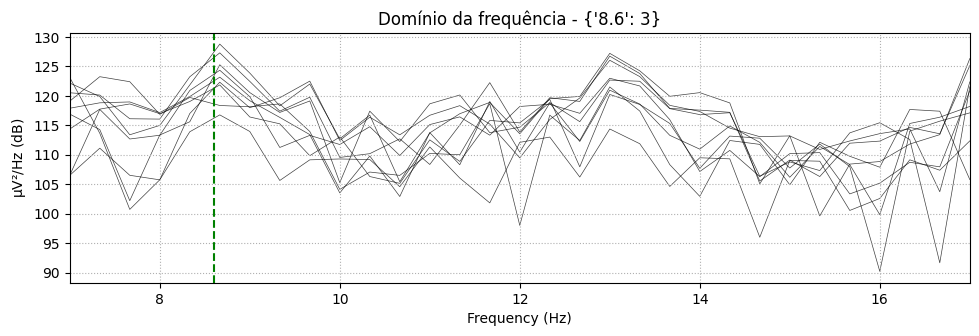

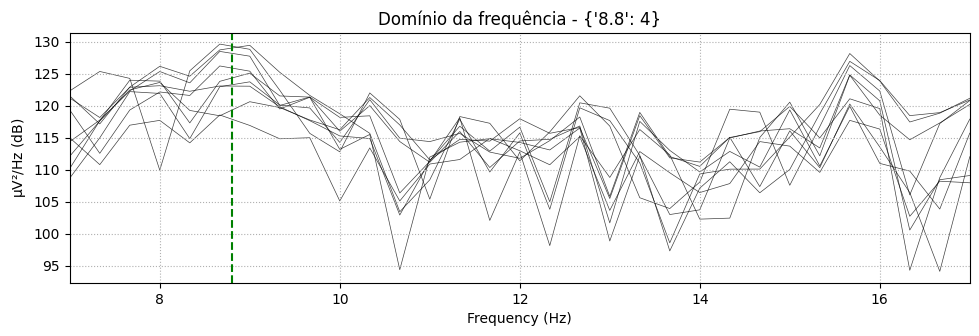

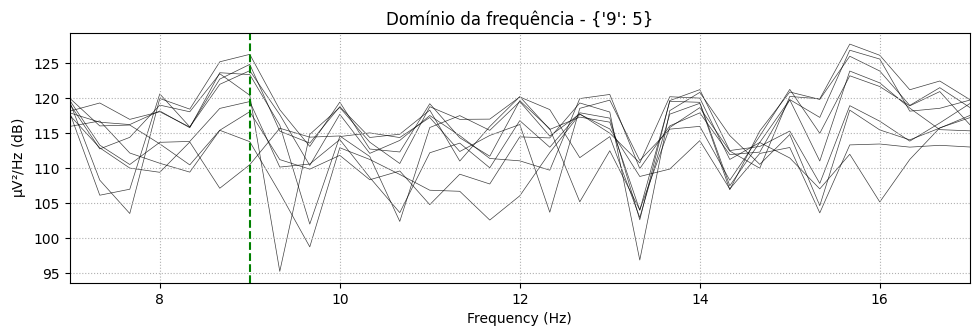

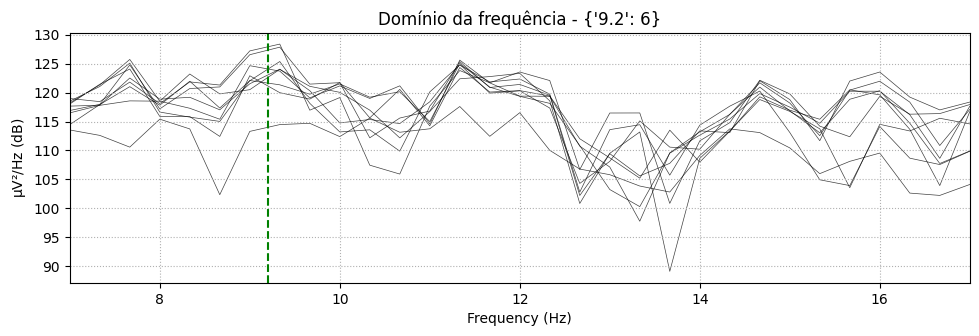

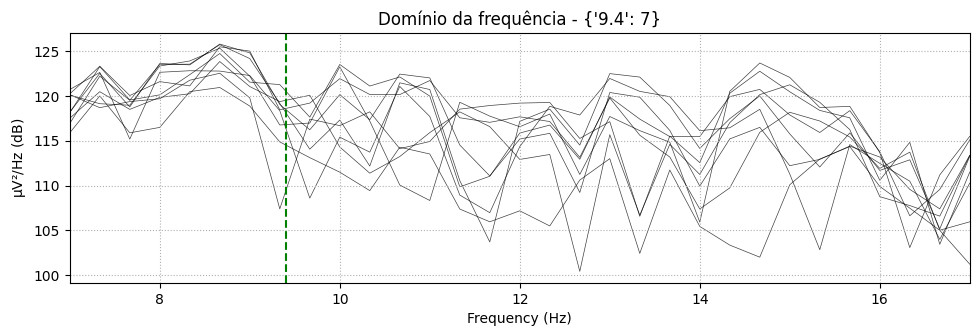

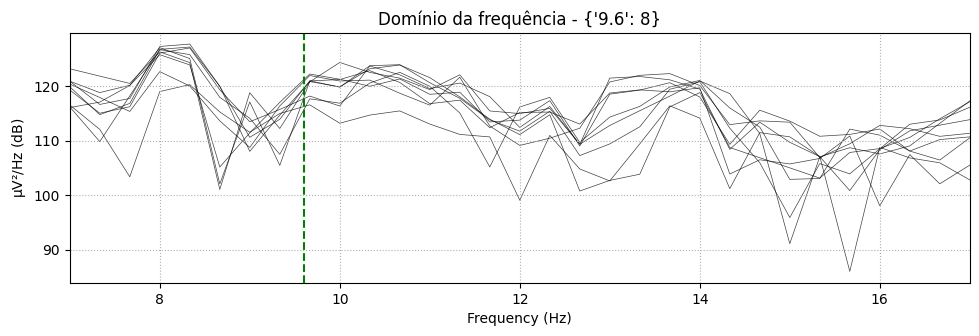

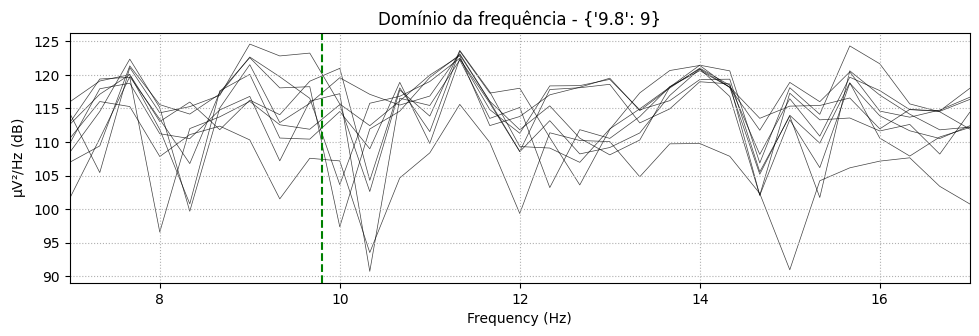

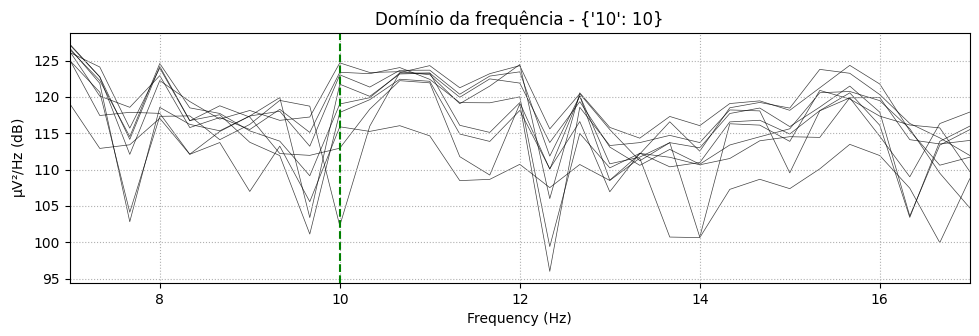

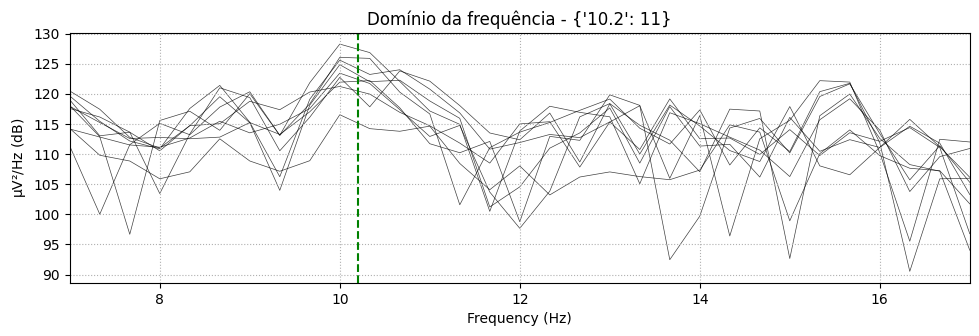

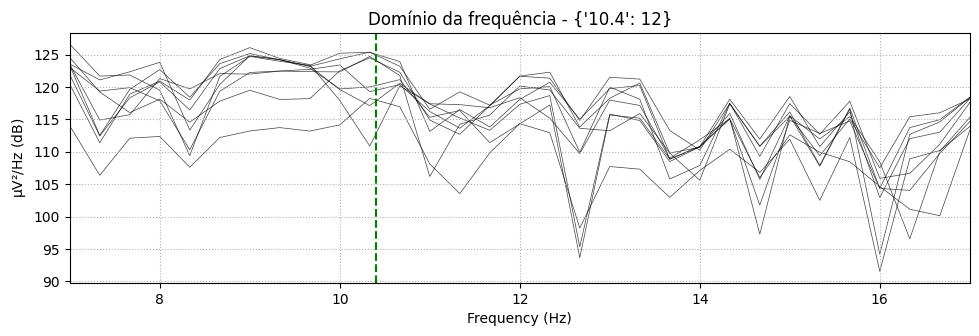

In [17]:
import warnings
warnings.filterwarnings('ignore')

channels_to_keep = ['PZ', 'PO3', 'PO5', 'PO4', 'PO6', 'POZ', 'O1', 'OZ', 'O2']
channels_to_remove = set(ch_names) - set(channels_to_keep)

print(mne_data)

mne_data = mne_data.drop_channels(list(channels_to_remove))
qtd_data = len(mne_data)

for i in range(0, 10):
    view = mne_data[i].compute_psd(method='welch', fmin=7, fmax=17, verbose=False)
        
    view.plot(show=False)
    plt.title(f'Domínio da frequência - {view.event_id}')
    plt.axvline(x=float(list(mne_data[i].event_id)[0]), linestyle='--', color='green')
    plt.show()

# Classificação por frequencia

In [16]:
threshold = 0.2
freqs = data[1]['freqs'][0][0].flatten()

y_pred = []

#para todas as instancias
for i in range(len(mne_data_drop)):
  
    item = mne_data_drop[i].compute_psd(method='welch', fmin=7.5, fmax=16.5, verbose=False)
    
    #pegar media de cada faixa de frequencia
    classes = []
    for freq in freqs:        
        classes.append( item.get_data(fmin=freq-threshold, fmax=freq+threshold).mean() )
    
    #verificar qual é a maior faixa de freq
    y_pred.append( freqs[np.argmax(classes)] )
    
acuracia = sum(y_pred == labels) / len(labels)
print('Acurácia:',acuracia)

Acurácia: 0.15625
